In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

# Pre-Processing Data

In [3]:
data = pd.read_csv('datakaltim.csv')
data.head()

,Tanggal,Harga (Rp)
0,01/01/2021,"11,900"
1,02/01/2021,"12,567"
2,03/01/2021,"12,456"
3,04/01/2021,"12,350"
4,05/01/2021,"12,350"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     1338 non-null   object
 1   Harga (Rp)  1338 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB


In [5]:
data.describe()

,Tanggal,Harga (Rp)
count,1338,1338
unique,1338,206
top,30/08/2024,"12,350"
freq,1,171


In [ ]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')

data['Harga (Rp)'] = pd.to_numeric(data['Harga (Rp)'].astype(str).str.replace(',', ''), errors='coerce')

data.set_index('Tanggal', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1338 entries, 2021-01-01 to 2024-08-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Harga (Rp)  1338 non-null   int64
dtypes: int64(1)
memory usage: 20.9 KB


(None,
             Harga (Rp)
 Tanggal               
 2021-01-01       11900
 2021-01-02       12567
 2021-01-03       12456
 2021-01-04       12350
 2021-01-05       12350)

In [16]:
data.describe()

,Harga (Rp),Harga_diff
count,1338.000000,1337.000000
mean,13524.634529,3.141361
std,1499.837549,189.099786
min,11200.000000,-1700.000000
25%,12350.000000,0.000000
50%,12550.000000,0.000000
75%,14833.500000,0.000000
max,16900.000000,1850.000000


# Exploratory Data Analysis (EDA)

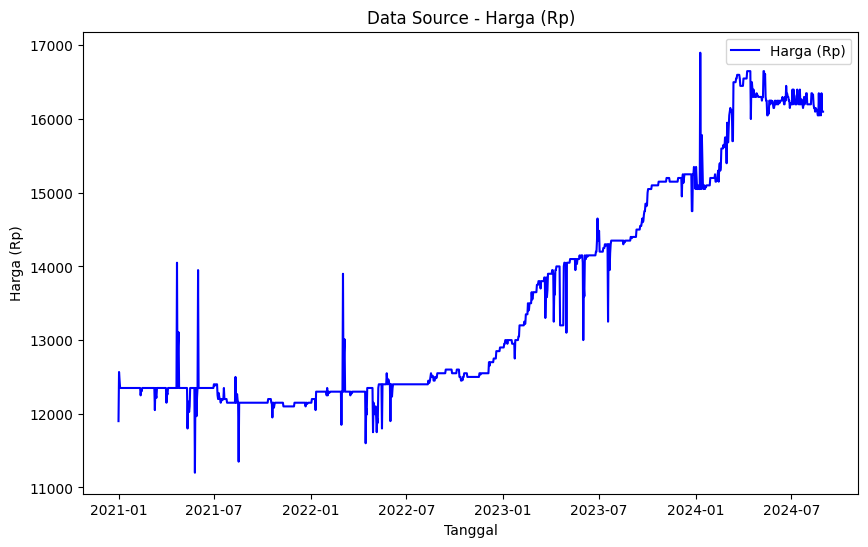

In [7]:
def plot_data_source(data):
    plt.figure(figsize=(10,6))
    plt.plot(data.index, data['Harga (Rp)'], label='Harga (Rp)', color='blue')
    plt.title('Data Source - Harga (Rp)')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (Rp)')
    plt.legend()
    plt.show()
plot_data_source(data)

In [8]:
data['Harga_diff'] = data['Harga (Rp)'].diff()

data_diff = data.dropna()

data_diff.head()

,Harga (Rp),Harga_diff
Tanggal,,
2021-01-02,12567,667.0
2021-01-03,12456,-111.0
2021-01-04,12350,-106.0
2021-01-05,12350,0.0
2021-01-06,12350,0.0


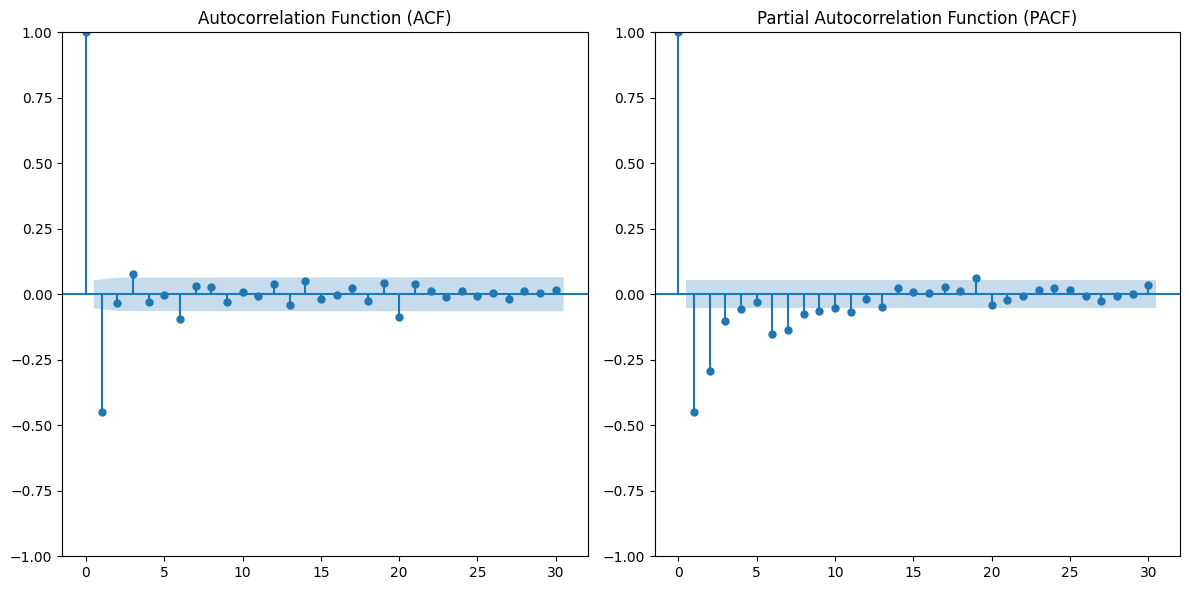

In [ ]:
def plot_acf_pacf(series, lags=30):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.subplot(122)
    plot_pacf(series, lags=lags, method='ywm', ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()

plot_acf_pacf(data_diff['Harga_diff'])

In [10]:
train_size_80 = int(len(data) * 0.8)
train_size_70 = int(len(data) * 0.7)
train_size_60 = int(len(data) * 0.6)

train_80, test_80 = data[:train_size_80], data[train_size_80:]
train_70, test_70 = data[:train_size_70], data[train_size_70:]
train_60, test_60 = data[:train_size_60], data[train_size_60:]

(train_80.shape, test_80.shape), (train_70.shape, test_70.shape), (train_60.shape, test_60.shape)

(((1070, 2), (268, 2)), ((936, 2), (402, 2)), ((802, 2), (536, 2)))

In [11]:
def evaluate_arima(train, test, order):
    model = ARIMA(train, order=order)
    arima_model = model.fit()

    predictions = arima_model.forecast(steps=len(test))

    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    r2 = r2_score(test, predictions)

    return predictions, mse, mae, r2

In [ ]:
data = data.drop('Harga_diff', axis=1)

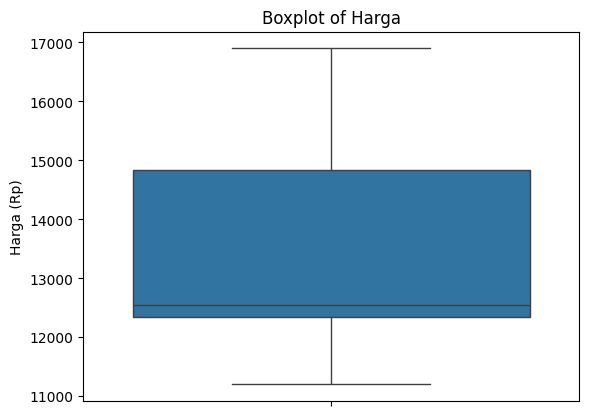

In [34]:
import seaborn as sns
sns.boxplot(data['Harga (Rp)'])
plt.title('Boxplot of Harga')
plt.show()

In [35]:
Q1 = data['Harga (Rp)'].quantile(0.25)
Q3 = data['Harga (Rp)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = data[(data['Harga (Rp)'] < lower_bound) | (data['Harga (Rp)'] > upper_bound)]

print(f"IQR Method - Outlier Detection Results:")
print(f"Q1: {Q1:,.0f}")
print(f"Q3: {Q3:,.0f}")
print(f"IQR: {IQR:,.0f}")
print(f"Lower Bound: {lower_bound:,.0f}")
print(f"Upper Bound: {upper_bound:,.0f}")
print(f"Number of outliers: {len(outliers_iqr)}")
print(f"Percentage of outliers: {len(outliers_iqr)/len(data)*100:.2f}%")

IQR Method - Outlier Detection Results:
Q1: 12,350
Q3: 14,834
IQR: 2,484
Lower Bound: 8,625
Upper Bound: 18,559
Number of outliers: 0
Percentage of outliers: 0.00%


In [47]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(data['Harga (Rp)']))
threshold = 2

outliers_zscore = data[z_scores > threshold]

print(f"Z-Score Method - Outlier Detection Results:")
print(f"Threshold: {threshold}")
print(f"Number of outliers: {len(outliers_zscore)}")
print(f"Percentage of outliers: {len(outliers_zscore)/len(data)*100:.2f}%")
print(f"Max Z-score: {z_scores.max():.2f}")
print(f"Min Z-score: {z_scores.min():.2f}")

Z-Score Method - Outlier Detection Results:
Threshold: 2
Number of outliers: 27
Percentage of outliers: 2.02%
Max Z-score: 2.25
Min Z-score: 0.02


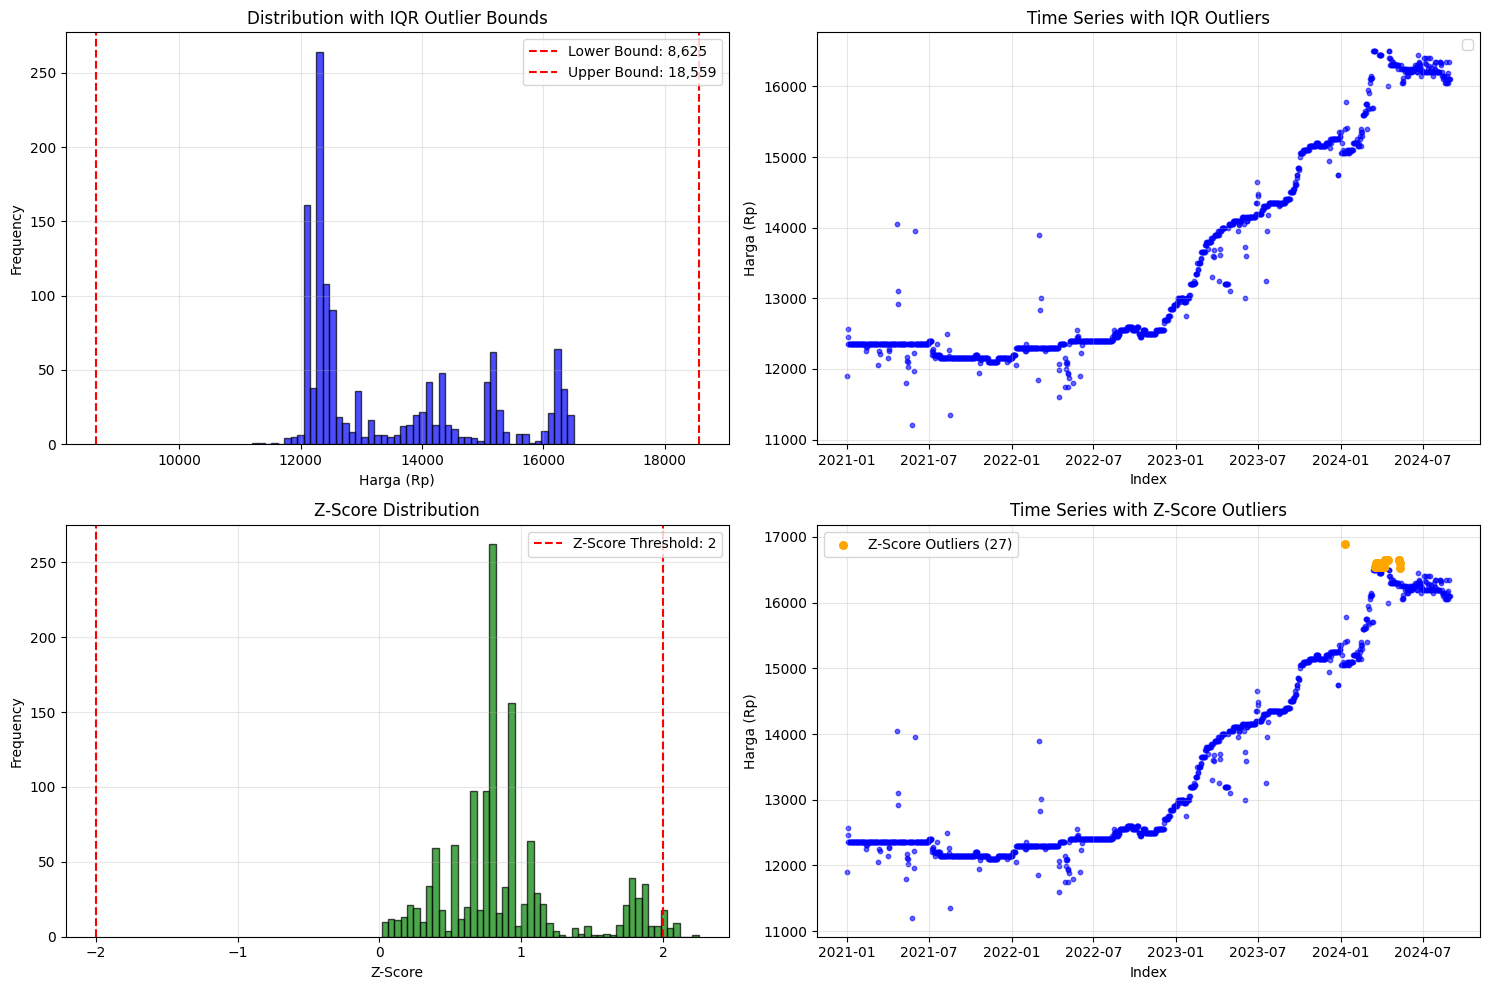

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(data['Harga (Rp)'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:,.0f}')
axes[0, 0].axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:,.0f}')
axes[0, 0].set_title('Distribution with IQR Outlier Bounds')
axes[0, 0].set_xlabel('Harga (Rp)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(data.index, data['Harga (Rp)'], alpha=0.6, color='blue', s=10)
if len(outliers_iqr) > 0:
    axes[0, 1].scatter(outliers_iqr.index, outliers_iqr['Harga (Rp)'], 
                      color='red', s=30, label=f'IQR Outliers ({len(outliers_iqr)})')
axes[0, 1].set_title('Time Series with IQR Outliers')
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Harga (Rp)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(z_scores, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].axvline(threshold, color='red', linestyle='--', label=f'Z-Score Threshold: {threshold}')
axes[1, 0].axvline(-threshold, color='red', linestyle='--')
axes[1, 0].set_title('Z-Score Distribution')
axes[1, 0].set_xlabel('Z-Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(data.index, data['Harga (Rp)'], alpha=0.6, color='blue', s=10)
if len(outliers_zscore) > 0:
    axes[1, 1].scatter(outliers_zscore.index, outliers_zscore['Harga (Rp)'], 
                      color='orange', s=30, label=f'Z-Score Outliers ({len(outliers_zscore)})')
axes[1, 1].set_title('Time Series with Z-Score Outliers')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Harga (Rp)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# 2. Bersihkan data dan overwrite ke `data`
cleaned_data = data[z_scores <= threshold].copy()
removed_count = len(data) - len(cleaned_data)

print("\n🧹 Cleaning and Overwriting:")
print(f"Original data points: {len(data)}")
print(f"Cleaned data points: {len(cleaned_data)}")
print(f"Removed outliers: {removed_count} ({removed_count/len(data)*100:.2f}%)")

# overwrite
data = cleaned_data

ValueError: Item wrong length 1338 instead of 1311.

In [51]:
print("=== OUTLIER DETECTION SUMMARY ===")
print()

if len(outliers_iqr) > 0:
    print("IQR Method Outliers:")
    print(f"- Total outliers: {len(outliers_iqr)}")
    print(f"- Percentage: {len(outliers_iqr)/len(data)*100:.2f}%")
    print(f"- Min outlier value: {outliers_iqr['Harga (Rp)'].min():,.0f}")
    print(f"- Max outlier value: {outliers_iqr['Harga (Rp)'].max():,.0f}")
    print(f"- Outlier indices: {list(outliers_iqr.index[:10])}{'...' if len(outliers_iqr) > 10 else ''}")
else:
    print("IQR Method: No outliers detected")

print()

if len(outliers_zscore) > 0:
    print("Z-Score Method Outliers:")
    print(f"- Total outliers: {len(outliers_zscore)}")
    print(f"- Percentage: {len(outliers_zscore)/len(data)*100:.2f}%")
    print(f"- Min outlier value: {outliers_zscore['Harga (Rp)'].min():,.0f}")
    print(f"- Max outlier value: {outliers_zscore['Harga (Rp)'].max():,.0f}")
    print(f"- Outlier indices: {list(outliers_zscore.index[:10])}{'...' if len(outliers_zscore) > 10 else ''}")
else:
    print("Z-Score Method: No outliers detected")

print()
print("=== COMPARISON ===")
print(f"Data points: {len(data)}")
print(f"IQR outliers: {len(outliers_iqr)} ({len(outliers_iqr)/len(data)*100:.2f}%)")
print(f"Z-Score outliers: {len(outliers_zscore)} ({len(outliers_zscore)/len(data)*100:.2f}%)")

if len(outliers_iqr) > 0 and len(outliers_zscore) > 0:
    common_outliers = set(outliers_iqr.index) & set(outliers_zscore.index)
    print(f"Common outliers: {len(common_outliers)}")
elif len(outliers_iqr) == 0 and len(outliers_zscore) == 0:
    print("Both methods agree: No outliers detected")
    print("This suggests the data has a normal distribution without extreme values")

=== OUTLIER DETECTION SUMMARY ===

IQR Method: No outliers detected

Z-Score Method Outliers:
- Total outliers: 27
- Percentage: 2.06%
- Min outlier value: 16,533
- Max outlier value: 16,900
- Outlier indices: [Timestamp('2024-01-10 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'), Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'), Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-23 00:00:00'), Timestamp('2024-03-24 00:00:00'), Timestamp('2024-03-25 00:00:00'), Timestamp('2024-04-01 00:00:00')]...

=== COMPARISON ===
Data points: 1311
IQR outliers: 0 (0.00%)
Z-Score outliers: 27 (2.06%)


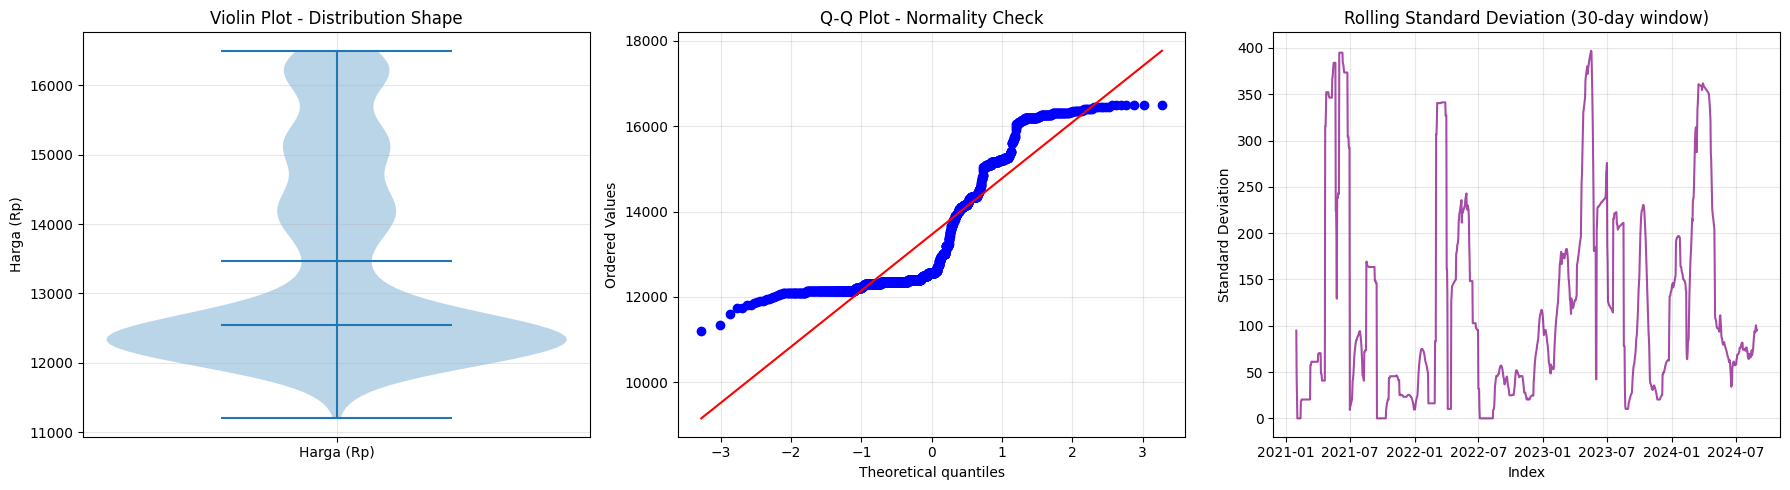

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

violin_data = [data['Harga (Rp)']]
violin_labels = ['Harga (Rp)']

parts = axes[0].violinplot(violin_data, positions=[1], showmeans=True, showmedians=True)
axes[0].set_xticks([1])
axes[0].set_xticklabels(violin_labels)
axes[0].set_title('Violin Plot - Distribution Shape')
axes[0].set_ylabel('Harga (Rp)')
axes[0].grid(True, alpha=0.3)

if len(outliers_iqr) > 0:
    axes[0].scatter([1]*len(outliers_iqr), outliers_iqr['Harga (Rp)'], 
                   color='red', alpha=0.7, s=20, label='IQR Outliers')
    axes[0].legend()

from scipy.stats import probplot
probplot(data['Harga (Rp)'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Normality Check')
axes[1].grid(True, alpha=0.3)

rolling_std = data['Harga (Rp)'].rolling(window=30).std()
axes[2].plot(data.index, rolling_std, color='purple', alpha=0.7)
axes[2].set_title('Rolling Standard Deviation (30-day window)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Standard Deviation')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ARIMA 80-20

## Modelling

In [53]:
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

results = []

p_values = [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 18]
q_values = [1, 3, 6, 20]

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(train['Harga (Rp)'], order=(p, 2, q))
            model_fit = model.fit()

            forecast = model_fit.forecast(steps=len(test))

            mse_arima = mean_squared_error(test['Harga (Rp)'], forecast)
            mape_arima = mean_absolute_percentage_error(test['Harga (Rp)'], forecast)

            results.append({'p': p, 
                            'q': q, 
                            'MSE': mse_arima, 
                            'MAPE': mape_arima,
                            'AIC': model_fit.aic,
                            'BIC': model_fit.bic})

        except Exception as e:
            print(f"Model with p={p}, q={q} encountered an error: {e}")

results_df = pd.DataFrame(results)

best_mse = results_df.loc[results_df['MSE'].idxmin()]
best_mape = results_df.loc[results_df['MAPE'].idxmin()]
best_aic = results_df.loc[results_df['AIC'].idxmin()]
best_bic = results_df.loc[results_df['BIC'].idxmin()]

print(f"\n🏆 Best model by MSE: ARIMA({best_mse['p']}, 2, {best_mse['q']}) - MSE: {best_mse['MSE']:.2f}")
print(f"🏆 Best model by MAPE: ARIMA({best_mape['p']}, 2, {best_mape['q']}) - MAPE: {best_mape['MAPE']:.4f}")
print(f"🏆 Best model by AIC: ARIMA({best_aic['p']}, 2, {best_aic['q']}) - AIC: {best_aic['AIC']:.2f}")
print(f"🏆 Best model by BIC: ARIMA({best_bic['p']}, 2, {best_bic['q']}) - BIC: {best_bic['BIC']:.2f}")

Train size: 1048, Test size: 263

🏆 Best model by MSE: ARIMA(18.0, 2, 20.0) - MSE: 88529.78
🏆 Best model by MAPE: ARIMA(18.0, 2, 20.0) - MAPE: 0.0153
🏆 Best model by AIC: ARIMA(8.0, 2, 6.0) - AIC: 13539.39
🏆 Best model by BIC: ARIMA(4.0, 2, 3.0) - BIC: 13590.13


## Evaluation

In [13]:
order_80 = (8, 2, 20)

train_80_values = train_80['Harga (Rp)']
test_80_values = test_80['Harga (Rp)']

predictions_80, mse_80, mae_80, r2_80 = evaluate_arima(train_80_values, test_80_values, order_80)

print(f"MSE (80-20 Split): {mse_80}")
print(f"MAE (80-20 Split): {mae_80}")
print(f"R2 Score (80-20 Split): {r2_80}")

average_test_value = np.mean(test_80_values)

mse_percentage80 = (mse_80 / (average_test_value ** 2)) * 100

mae_percentage80 = (mae_80 / average_test_value) * 100

r2_percentage80 = r2_80 * 100

print(f"MSE Percentage 80: {mse_percentage80}%")
print(f"MAE Percentage 80: {mae_percentage80}%")
print(f"r2 Percentage 80: {r2_percentage80}%")

MSE (80-20 Split): 143437.53556381149
MAE (80-20 Split): 286.2229032998256
R2 Score (80-20 Split): 0.468772198445645
MSE Percentage 80: 0.05629688225489488%
MAE Percentage 80: 1.7931439170597572%
r2 Percentage 80: 46.8772198445645%


## Implementation

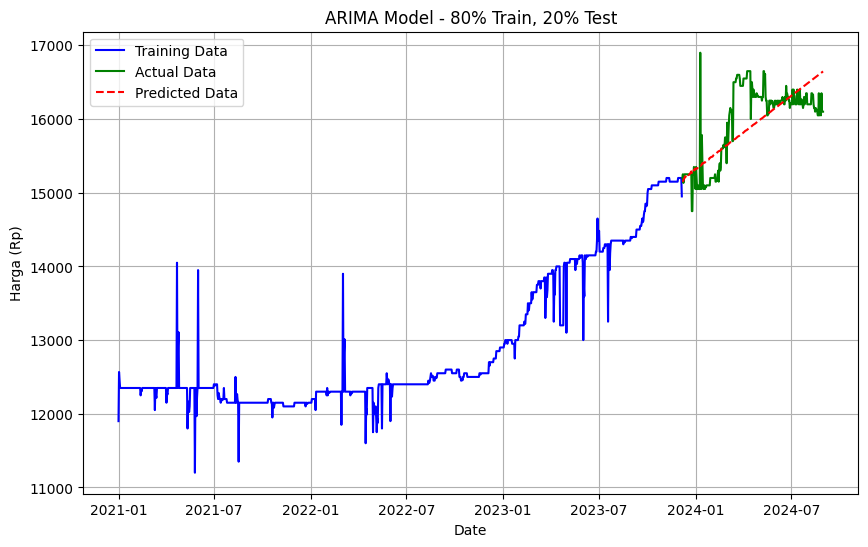

In [14]:
def plot_predictions(train, test, predictions, title):
    plt.figure(figsize=(10,6))

    plt.plot(train.index, train, label='Training Data', color='blue')

    plt.plot(test.index, test, label='Actual Data', color='green')

    plt.plot(test.index, predictions, label='Predicted Data', color='red', linestyle='dashed')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Harga (Rp)')
    plt.legend()

    plt.grid(True)

    plt.show()

plot_predictions(train_80['Harga (Rp)'], test_80['Harga (Rp)'], predictions_80, 'ARIMA Model - 80% Train, 20% Test')

In [15]:
extended_forecast_period_80 = 365

extended_forecast_80 = model_full_fit_80.forecast(steps=extended_forecast_period_80)

last_date_80 = data_80.index[-1]
future_dates_80 = pd.date_range(last_date_80, periods=extended_forecast_period_80 + 1, inclusive='right')

plt.figure(figsize=(10, 6))

plt.plot(data_80.index, data_80['Harga (Rp)'], label="Actual Prices", color="blue")

plt.plot(future_dates_80, extended_forecast_80, label="Forecasted Prices (1 Year)", color="green", linestyle="--")

plt.title("ARIMA Model - Extended Forecast for 1 Year (80-20 Split)")
plt.xlabel("Date")
plt.ylabel("Price (Rp)")

plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'model_full_fit_80' is not defined

In [ ]:
extended_forecast_df = pd.DataFrame({
    'Date': future_dates_80,
    'Forecasted Price (Rp)': extended_forecast_80
})

extended_forecast_df.to_csv('arima80.csv', header=True)

print("Hasil forecast telah disimpan ke 'hasil_forecast_manual_arima.csv'.")

Hasil forecast telah disimpan ke 'hasil_forecast_manual_arima.csv'.


# ARIMA 70-30

## Modelling

In [ ]:
train, test = train_test_split(data, train_size=0.7, test_size=0.3, shuffle=False)

results = []

p_values = [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 18]
q_values = [1, 3, 6, 20]

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(train['Harga (Rp)'], order=(p, 2, q))
            model_fit = model.fit()

            future_steps_70 = 767
            forecast = model_fit.forecast(steps=future_steps_70)

            forecast = forecast[:len(test)]

            mse_arima = mean_squared_error(test['Harga (Rp)'], forecast)
            mape_arima = mean_absolute_percentage_error(test['Harga (Rp)'], forecast)

            results.append({'p': p, 'q': q, 'MSE': mse_arima, 'MAPE': mape_arima})

        except Exception as e:
            print(f"Model with p={p}, q={q} encountered an error: {e}")

results_df = pd.DataFrame(results)

print(results_df)

best_model_mse = results_df.loc[results_df['MSE'].idxmin()]
print("\nBest model based on MSE:")
print(best_model_mse)

best_model_mape = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest model based on MAPE:")
print(best_model_mape)

c:\Users\Devy Relliani\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Devy Relliani\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Devy Relliani\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Devy Relliani\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Devy Relliani\AppDa

KeyboardInterrupt: 

In [ ]:
data_70 = data
data_70

,Harga (Rp),Harga_diff
Tanggal,,
2021-01-01,11900,NaN
2021-01-02,12567,667.0
2021-01-03,12456,-111.0
2021-01-04,12350,-106.0
2021-01-05,12350,0.0
...,...,...
2024-08-26,16050,-133.0
2024-08-27,16350,300.0
2024-08-28,16100,-250.0


## Evaluation

In [ ]:
order_70 = (6, 2, 6)

train_70_values = train_70['Harga (Rp)']
test_70_values = test_70['Harga (Rp)']

predictions_70, mse_70, mae_70, r2_70 = evaluate_arima(train_70_values, test_70_values, order_70)

print(f"MSE (70-30 Split): {mse_70}")
print(f"MAE (70-30 Split): {mae_70}")
print(f"R2 Score (70-30 Split): {r2_70}")

average_test_value = np.mean(test_70_values)

mse_percentage70 = (mse_70 / (average_test_value ** 2)) * 100

mae_percentage70 = (mae_70 / average_test_value) * 100

r2_percentage70 = r2_70 * 100

print(f"MSE Percentage 70: {mse_percentage70}%")
print(f"MAE Percentage 70: {mae_percentage70}%")
print(f"r2 Percentage 70: {r2_percentage70}%")

MSE (70-30 Split): 199584.57421532884
MAE (70-30 Split): 330.51207431049346
R2 Score (70-30 Split): 0.6254436077471581
MSE Percentage 70: 0.08233877933563229%
MAE Percentage 70: 2.122882984431999%
r2 Percentage 70: 62.54436077471581%


## Implementation

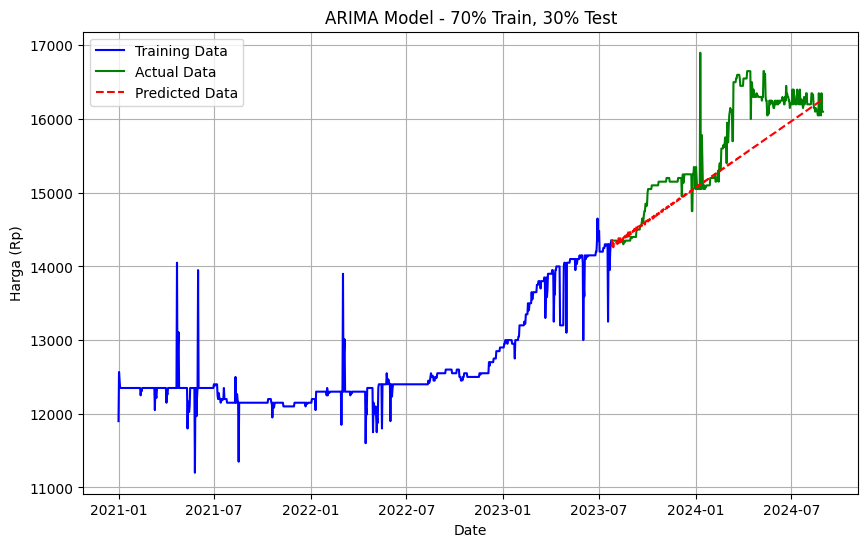

In [ ]:
def plot_predictions(train, test, predictions, title):
    plt.figure(figsize=(10,6))

    plt.plot(train.index, train, label='Training Data', color='blue')

    plt.plot(test.index, test, label='Actual Data', color='green')

    plt.plot(test.index, predictions, label='Predicted Data', color='red', linestyle='dashed')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Harga (Rp)')
    plt.legend()

    plt.grid(True)

    plt.show()

plot_predictions(train_70['Harga (Rp)'], test_70['Harga (Rp)'], predictions_70, 'ARIMA Model - 70% Train, 30% Test')

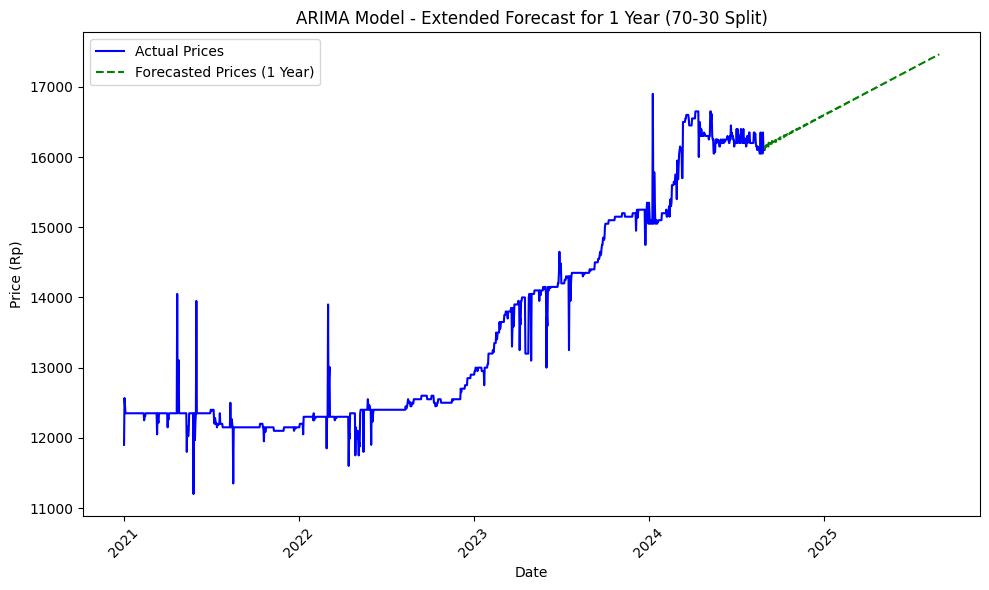

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

extended_forecast_period_70 = 365

model_full_70 = ARIMA(data_70['Harga (Rp)'], order=order_70)
model_full_fit_70 = model_full_70.fit()

extended_forecast_70 = model_full_fit_70.forecast(steps=extended_forecast_period_70)

last_date_70 = data_70.index[-1]
future_dates_70 = pd.date_range(last_date_70, periods=extended_forecast_period_70 + 1, inclusive='right')

plt.figure(figsize=(10, 6))

plt.plot(data_70.index, data_70['Harga (Rp)'], label="Actual Prices", color="blue")

plt.plot(future_dates_70, extended_forecast_70, label="Forecasted Prices (1 Year)", color="green", linestyle="--")

plt.title("ARIMA Model - Extended Forecast for 1 Year (70-30 Split)")
plt.xlabel("Date")
plt.ylabel("Price (Rp)")

plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
extended_forecast_df_70 = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Price (Rp)': extended_forecast
})

extended_forecast_df_70.to_csv('arima70.csv', header=True)

# ARIMA 60-40

## Modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

train, test = train_test_split(data, train_size=0.6, test_size=0.4, shuffle=False)

results = []

p_values = [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 18]
q_values = [1, 3, 6, 20]

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(train['Harga (Rp)'], order=(p, 2, q))
            model_fit = model.fit()

            future_steps_60 = 901
            forecast = model_fit.forecast(steps=future_steps_70)

            forecast = forecast[:len(test)]

            mse_arima = mean_squared_error(test['Harga (Rp)'], forecast)
            mape_arima = mean_absolute_percentage_error(test['Harga (Rp)'], forecast)

            results.append({'p': p, 'q': q, 'MSE': mse_arima, 'MAPE': mape_arima})

        except Exception as e:
            print(f"Model with p={p}, q={q} encountered an error: {e}")

results_df = pd.DataFrame(results)

print(results_df)

best_model_mse = results_df.loc[results_df['MSE'].idxmin()]
print("\nBest model based on MSE:")
print(best_model_mse)

best_model_mape = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest model based on MAPE:")
print(best_model_mape)

KeyboardInterrupt: 

In [ ]:
data_60 = data
data_60

,Harga (Rp),Harga_diff
Tanggal,,
2021-01-01,11900,NaN
2021-01-02,12567,667.0
2021-01-03,12456,-111.0
2021-01-04,12350,-106.0
2021-01-05,12350,0.0
...,...,...
2024-08-26,16050,-133.0
2024-08-27,16350,300.0
2024-08-28,16100,-250.0


## Evaluation

In [ ]:
order_60 = (10, 2, 1)

train_60_values = train_60['Harga (Rp)']
test_60_values = test_60['Harga (Rp)']

predictions_60, mse_60, mae_60, r2_60 = evaluate_arima(train_60_values, test_60_values, order_60)

print(f"MSE (60-40 Split): {mse_60}")
print(f"MAE (60-40 Split): {mae_60}")
print(f"R2 Score (60-40 Split): {r2_60}")

average_test_value = np.mean(test_60_values)

mse_percentage = (mse_60 / (average_test_value ** 2)) * 100

mae_percentage = (mae_60 / average_test_value) * 100

r2_percentage = r2_60 * 100

print(f"MSE Percentage: {mse_percentage}%")
print(f"MAE Percentage: {mae_percentage}%")
print(f"r2 Percentage: {r2_percentage}%")

MSE (60-40 Split): 158836.3632739794
MAE (60-40 Split): 316.9857209121005
R2 Score (60-40 Split): 0.8213688670317777
MSE Percentage: 0.06897648805259779%
MAE Percentage: 2.0888885578663374%
r2 Percentage: 82.13688670317777%


## Implementation

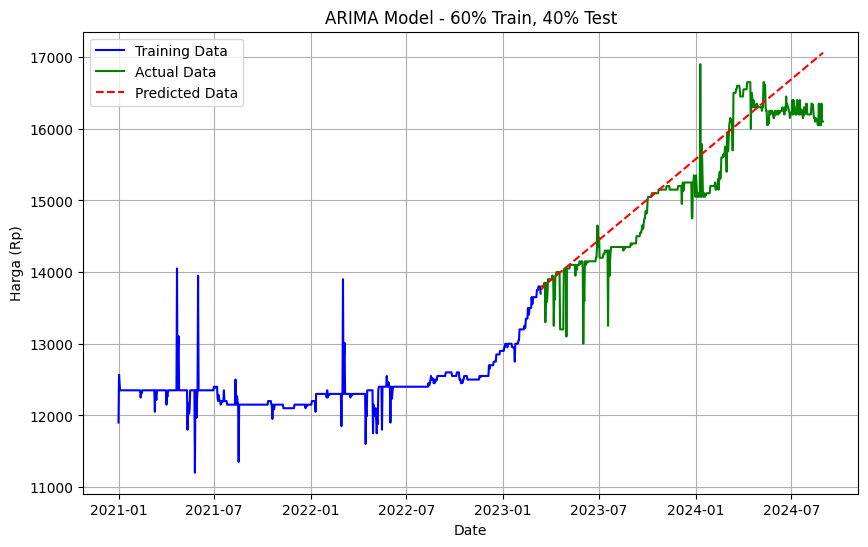

In [ ]:
def plot_predictions(train, test, predictions, title):
    plt.figure(figsize=(10,6))

    plt.plot(train.index, train, label='Training Data', color='blue')

    plt.plot(test.index, test, label='Actual Data', color='green')

    plt.plot(test.index, predictions, label='Predicted Data', color='red', linestyle='dashed')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Harga (Rp)')
    plt.legend()

    plt.grid(True)

    plt.show()

plot_predictions(train_60['Harga (Rp)'], test_60['Harga (Rp)'], predictions_60, 'ARIMA Model - 60% Train, 40% Test')

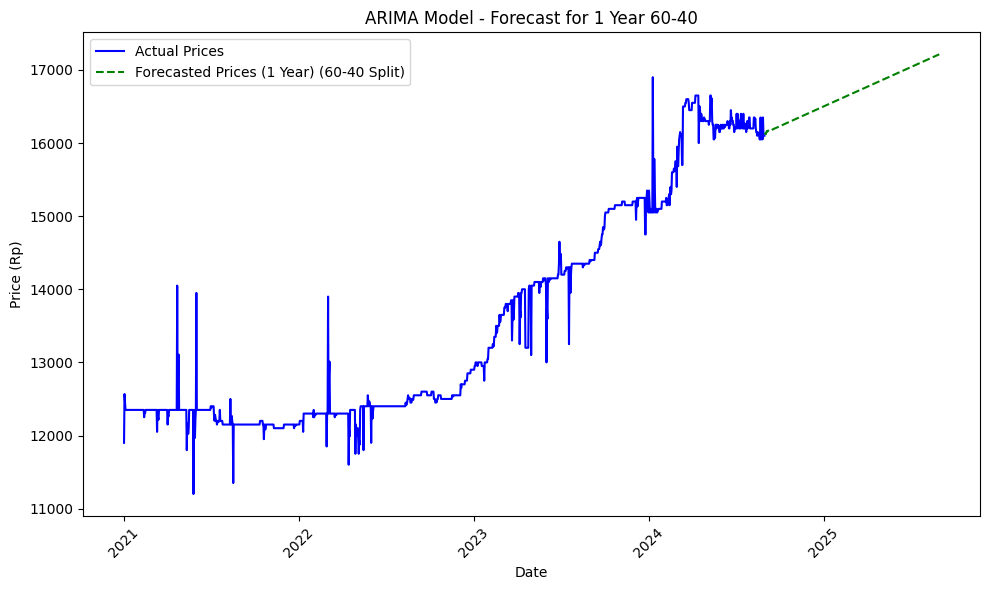

In [ ]:
extended_forecast_period = 365

model_full = ARIMA(data_60['Harga (Rp)'], order=order_60)
model_full_fit = model_full.fit()

extended_forecast = model_full_fit.forecast(steps=extended_forecast_period)

last_date = data_60.index[-1]
future_dates = pd.date_range(start=last_date, periods=extended_forecast_period + 1, freq='D')[1:]

plt.figure(figsize=(10, 6))

plt.plot(data_60.index, data_60['Harga (Rp)'], label="Actual Prices", color="blue")

plt.plot(future_dates, extended_forecast, label="Forecasted Prices (1 Year) (60-40 Split)", color="green", linestyle="--")

plt.title("ARIMA Model - Forecast for 1 Year 60-40")
plt.xlabel("Date")
plt.ylabel("Price (Rp)")

plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
extended_forecast_df_60 = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Price (Rp)': extended_forecast
})

extended_forecast_df_60.to_csv('arima60.csv', header=True)

print("Hasil forecast telah disimpan ke 'hasil_forecast_manual_arima.csv'.")

Hasil forecast telah disimpan ke 'hasil_forecast_manual_arima.csv'.


# LSTM RESIDUAL 80-20

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Modelling

In [ ]:
arraydata = df['Harga (Rp)'].values

In [ ]:
train_size = int(len(arraydata) * 0.8)
train_data, test_data = arraydata[:train_size], arraydata[train_size:]

In [ ]:
arima_order = (8, 2, 20)  # Tentukan parameter ARIMA yang optimal (p, d, q)
arima_model = ARIMA(train_data, order=arima_order)
arima_model_fit = arima_model.fit()

In [ ]:
arima_pred = arima_model_fit.forecast(steps=len(test_data))
arima_train_pred = arima_model_fit.fittedvalues

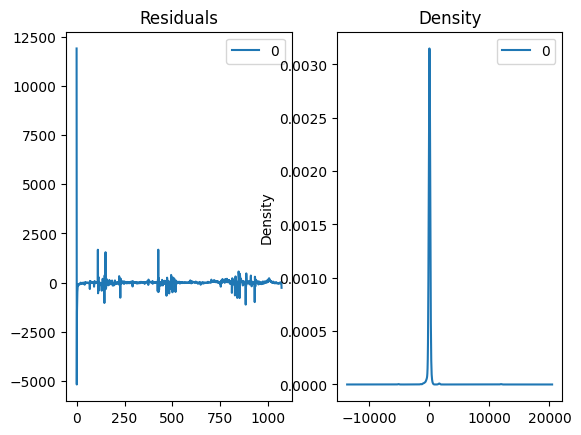

In [ ]:
import matplotlib.pyplot as plt
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

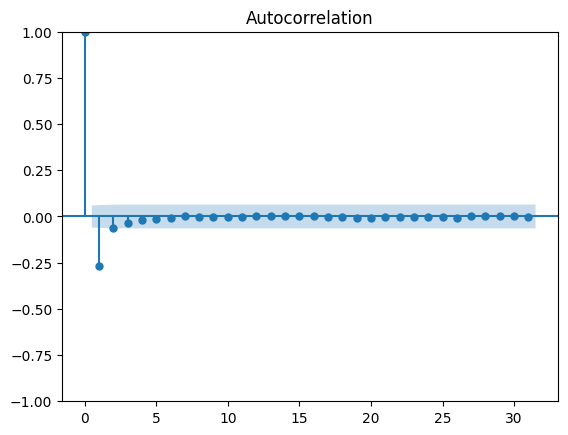

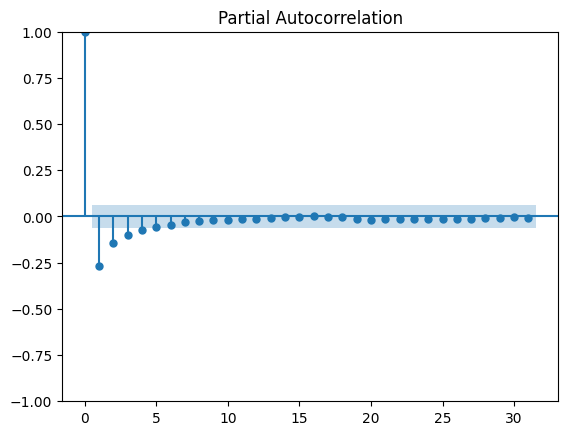

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_residuals = plot_acf(residuals)
pacf_residuals = plot_pacf(residuals)

In [ ]:
train_residual = train_data - arima_train_pred
test_residual = test_data - arima_pred

train_residual
test_residual

array([ 4.98148763e+01,  9.41527596e+01, -3.49255159e+01,  3.43189145e+00,
        5.43518266e+01,  2.88771560e+01,  3.45810085e+01,  2.67168749e+01,
        1.10476906e+01,  1.86042479e+00, -2.36982802e+00,  1.13074167e+01,
        6.69835192e+00,  3.49315868e-01, -2.15315644e+00, -1.36082661e+01,
       -2.65627859e+01, -3.99025454e+01, -5.19548271e+02, -5.44957424e+02,
       -3.26136213e+01, -3.81020717e+01,  4.29129458e+01, -2.37199927e+01,
       -3.41030652e+01, -2.67086218e+02,  2.54304173e+01, -1.28745032e+02,
       -2.77208820e+02, -2.87097324e+02, -2.51388215e+02, -2.93068303e+02,
       -3.07903214e+02, -3.17240502e+02,  1.53613139e+03,  3.07597834e+01,
       -3.24482887e+02,  3.97931302e+02,  1.11030640e+01, -2.96922013e+02,
       -3.54410468e+02, -3.06751467e+02, -3.06484825e+02, -3.62275134e+02,
       -3.40441908e+02, -3.56135087e+02, -3.37915575e+02, -3.42995014e+02,
       -3.45269554e+02, -3.47897626e+02, -3.49399477e+02, -3.60149673e+02,
       -3.71872594e+02, -

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.reshape(-1, 1))

In [ ]:
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_residual_scaled, look_back)
X_test, y_test = create_dataset(test_residual_scaled, look_back)

def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_residual_scaled, look_back)
X_test, y_test = create_dataset(test_residual_scaled, look_back)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0389
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0018
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.2057e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 9.4714e-05
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.6192e-05
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0838e-05
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.3741e-05
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.8472e-05
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 7.9180e-05
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 6.5437e-05
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.2018e-05
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 7.4829e-05
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9314e-05
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.8479e-05
Epoch 15/20
16/16 ━━━

In [ ]:
lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


In [ ]:
final_pred = arima_pred[-len(lstm_pred_rescaled):] + lstm_pred_rescaled.flatten()

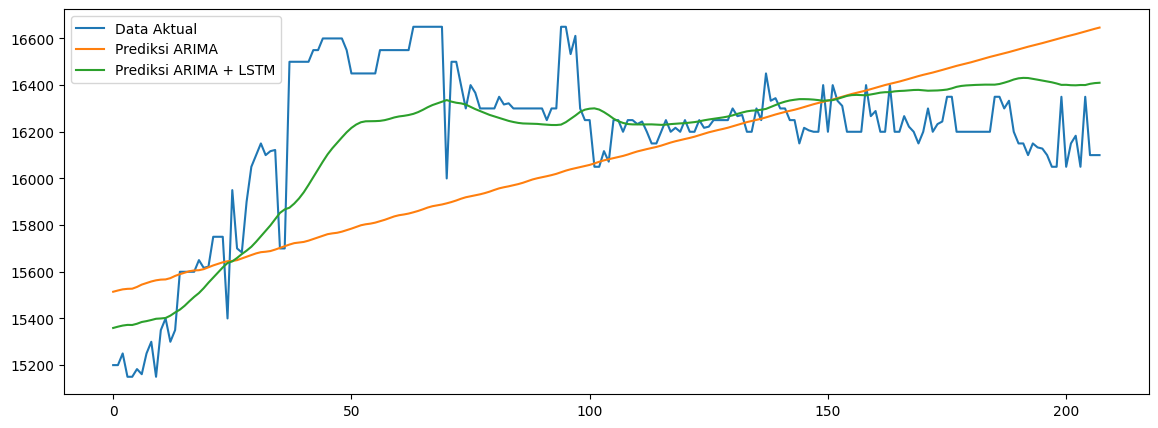

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(test_data[look_back:], label='Data Aktual')
plt.plot(arima_pred[-len(final_pred):], label='Prediksi ARIMA')
plt.plot(final_pred, label='Prediksi ARIMA + LSTM')
plt.legend()
plt.show()

## Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test_data[look_back:], final_pred)
mae = mean_absolute_error(test_data[look_back:], final_pred)
mape = np.mean(np.abs((test_data[look_back:] - final_pred) / test_data[look_back:])) * 100
r2 = r2_score(test_data[look_back:], final_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')

MSE: 49426.69013114657
MAE: 171.48615389420078
MAPE: 1.0565017451998002
R²: 0.5723610424010523


## Implementation

In [ ]:
lstm_input = test_residual_scaled[-look_back:]
lstm_input = lstm_input.reshape((1, look_back, 1))

In [ ]:
lstm_forecast_residuals = []
for _ in range(forecast_steps):
    lstm_pred_residual = lstm_model.predict(lstm_input)
    lstm_forecast_residuals.append(lstm_pred_residual[0, 0])

    lstm_input = np.append(lstm_input[0, 1:], lstm_pred_residual)
    lstm_input = lstm_input.reshape((1, look_back, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [ ]:
lstm_forecast_residuals_rescaled = scaler.inverse_transform(np.array(lstm_forecast_residuals).reshape(-1, 1))

In [ ]:
final_forecast = extended_forecast_80 + lstm_forecast_residuals_rescaled.flatten()

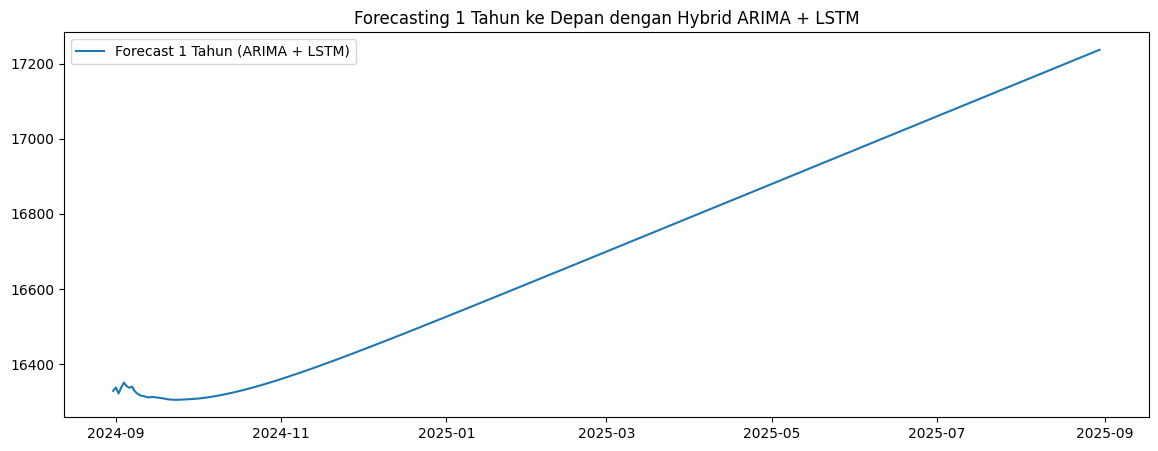

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)')
plt.title('Forecasting 1 Tahun ke Depan dengan Hybrid ARIMA + LSTM')
plt.legend()
plt.show()

In [ ]:
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, inclusive='right')
forecast_df = pd.DataFrame(final_forecast, index=forecast_dates, columns=['Forecast'])

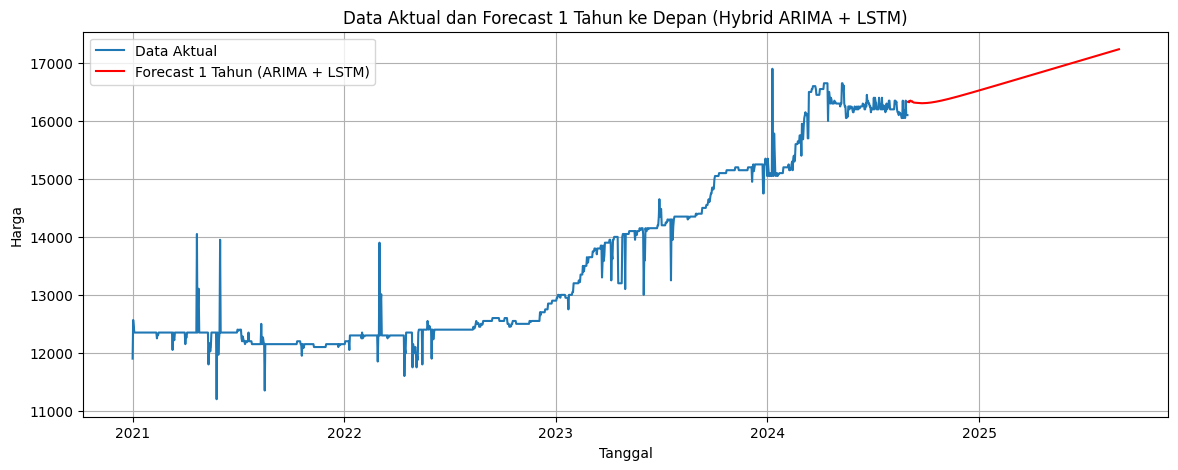

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Harga (Rp)'], label='Data Aktual')

plt.plot(forecast_dates, final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)', color='red')

plt.title('Data Aktual dan Forecast 1 Tahun ke Depan (Hybrid ARIMA + LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
final_forecast.to_csv('hybrid80.csv', header=True)

# LSTM RESIDUAL 70-30


## Modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
df = pd.read_csv('datakaltim.csv')  # Pastikan file ini berisi kolom time series
df['Tanggal'] = pd.to_datetime(df['Tanggal'])  # Sesuaikan dengan kolom tanggal Anda
df.set_index('Tanggal', inplace=True)

In [ ]:
arraydata = df['Harga (Rp)'].values

In [ ]:
train_size = int(len(arraydata) * 0.8)
train_data, test_data = arraydata[:train_size], arraydata[train_size:]

In [ ]:
arima_order = (6, 2, 6)  # Tentukan parameter ARIMA yang optimal (p, d, q)
arima_model = ARIMA(train_data, order=arima_order)
arima_model_fit = arima_model.fit()

In [ ]:
arima_pred = arima_model_fit.forecast(steps=len(test_data))
arima_train_pred = arima_model_fit.fittedvalues

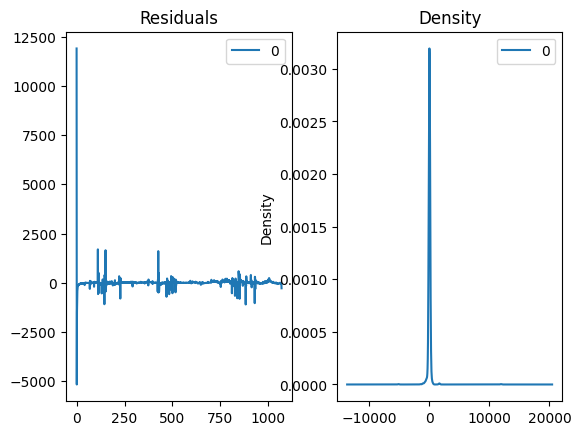

In [ ]:
import matplotlib.pyplot as plt
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

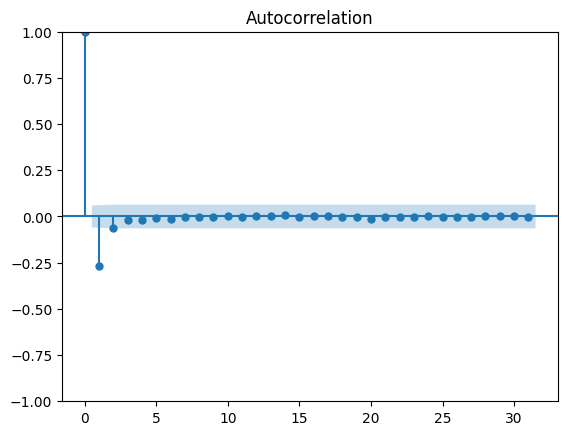

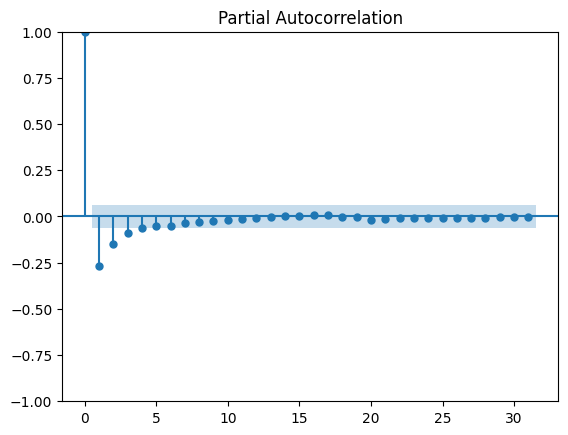

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_residuals = plot_acf(residuals)
pacf_residuals = plot_pacf(residuals)

In [ ]:
train_residual = train_data - arima_train_pred
test_residual = test_data - arima_pred

train_residual
test_residual

array([ 5.62264684e+01,  1.02949561e+02, -6.09627770e+01, -3.05508782e+00,
        3.06295472e+01,  2.03006433e+01,  1.53284305e+01,  5.06854241e+00,
        5.34935254e-01, -7.31668702e+00, -1.64210083e+01, -1.55115730e+01,
       -2.54665126e+01, -3.66387934e+01, -3.29940937e+01, -4.20263163e+01,
       -5.47899507e+01, -5.21834817e+01, -5.59367041e+02, -5.70755611e+02,
       -7.14226412e+01, -7.85464727e+01,  1.40270002e+01, -5.62538245e+01,
       -5.47940507e+01, -3.02202034e+02, -5.75147821e+00, -1.68413357e+02,
       -3.20040042e+02, -3.22287735e+02, -2.86336692e+02, -3.21592813e+02,
       -3.40182849e+02, -3.52950342e+02,  1.49353481e+03, -9.55114644e+00,
       -3.69574980e+02,  3.59938993e+02, -1.83179074e+01, -3.37212233e+02,
       -3.89033598e+02, -3.48254659e+02, -3.55725769e+02, -4.05599142e+02,
       -3.83020699e+02, -3.96109782e+02, -3.73439781e+02, -3.83314734e+02,
       -3.91481683e+02, -3.92190410e+02, -4.01114869e+02, -4.07854914e+02,
       -4.10881117e+02, -

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.reshape(-1, 1))

In [ ]:
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_residual_scaled, look_back)
X_test, y_test = create_dataset(test_residual_scaled, look_back)

def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_residual_scaled, look_back)
X_test, y_test = create_dataset(test_residual_scaled, look_back)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0384
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0020
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 4.6343e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 1.1802e-04
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.1991e-04
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.7607e-05
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 8.6231e-05
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.7587e-05
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.0553e-04
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 7.0770e-05
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 7.4629e-05
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 9.0236e-05
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.4009e-05
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.9917e-05
Epoch 15/20
16/16 ━

In [ ]:
# 11. Prediksi residual menggunakan LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [ ]:
# 12. Gabungkan hasil prediksi ARIMA dan LSTM (prediksi residual)
final_pred = arima_pred[-len(lstm_pred_rescaled):] + lstm_pred_rescaled.flatten()


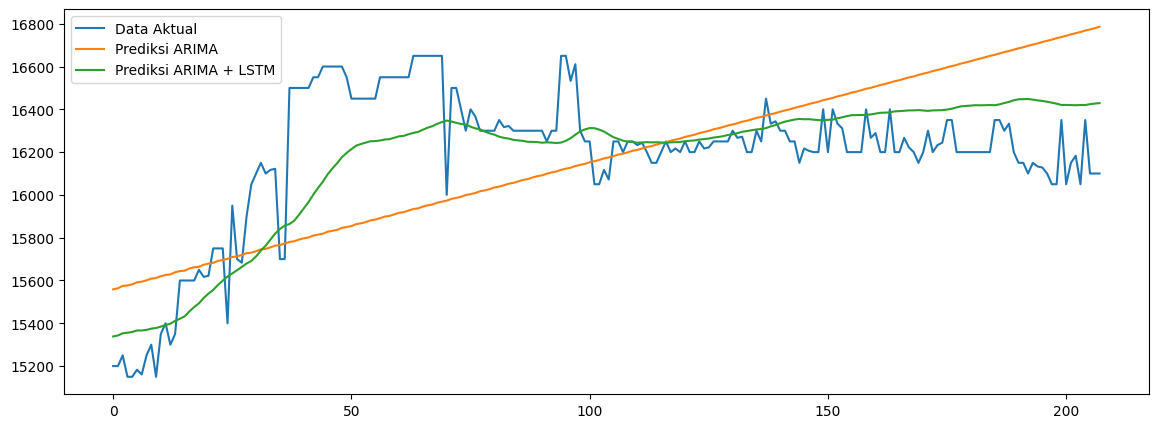

In [ ]:
# 13. Plot hasil akhir
plt.figure(figsize=(14, 5))
plt.plot(test_data[look_back:], label='Data Aktual')
plt.plot(arima_pred[-len(final_pred):], label='Prediksi ARIMA')
plt.plot(final_pred, label='Prediksi ARIMA + LSTM')
plt.legend()
plt.show()


## Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test_data[look_back:], final_pred)
mae = mean_absolute_error(test_data[look_back:], final_pred)
mape = np.mean(np.abs((test_data[look_back:] - final_pred) / test_data[look_back:])) * 100
r2 = r2_score(test_data[look_back:], final_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')

MSE: 55117.07194867878
MAE: 185.64795838899732
MAPE: 1.144241311525454
R²: 0.5231279470363268


## Implementation

In [ ]:
lstm_input = test_residual_scaled[-look_back:]
lstm_input = lstm_input.reshape((1, look_back, 1))

In [ ]:
lstm_forecast_residuals = []
for _ in range(forecast_steps):
    lstm_pred_residual = lstm_model.predict(lstm_input)
    lstm_forecast_residuals.append(lstm_pred_residual[0, 0])

    lstm_input = np.append(lstm_input[0, 1:], lstm_pred_residual)
    lstm_input = lstm_input.reshape((1, look_back, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [ ]:
lstm_forecast_residuals_rescaled = scaler.inverse_transform(np.array(lstm_forecast_residuals).reshape(-1, 1))

In [ ]:
final_forecast = extended_forecast_70 + lstm_forecast_residuals_rescaled.flatten()

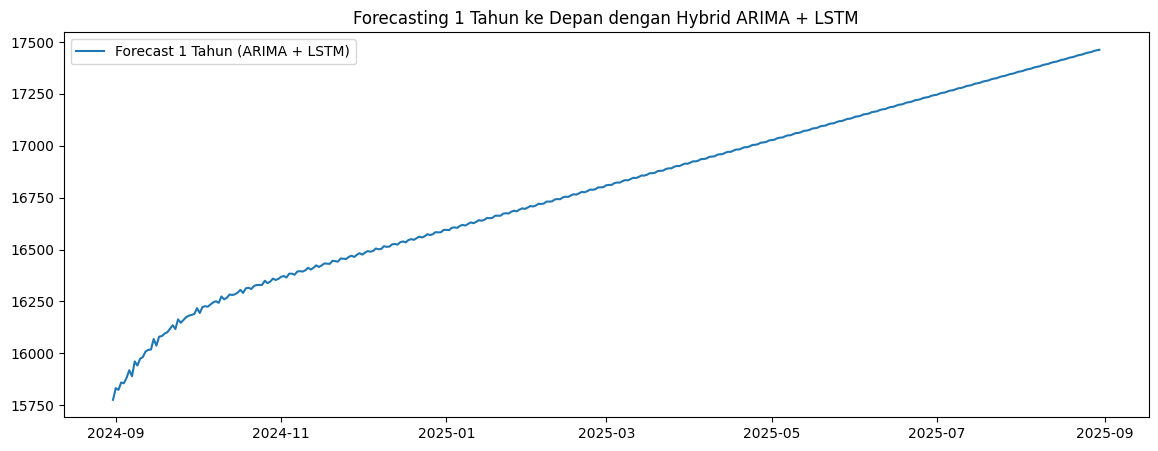

In [ ]:
# 5. Plot hasil prediksi 1 tahun ke depan
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)')
plt.title('Forecasting 1 Tahun ke Depan dengan Hybrid ARIMA + LSTM')
plt.legend()
plt.show()

In [ ]:
# 6. Print hasil prediksi (opsional)
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, inclusive='right') # Use inclusive='right' instead of closed='right'
forecast_df = pd.DataFrame(final_forecast, index=forecast_dates, columns=['Forecast'])

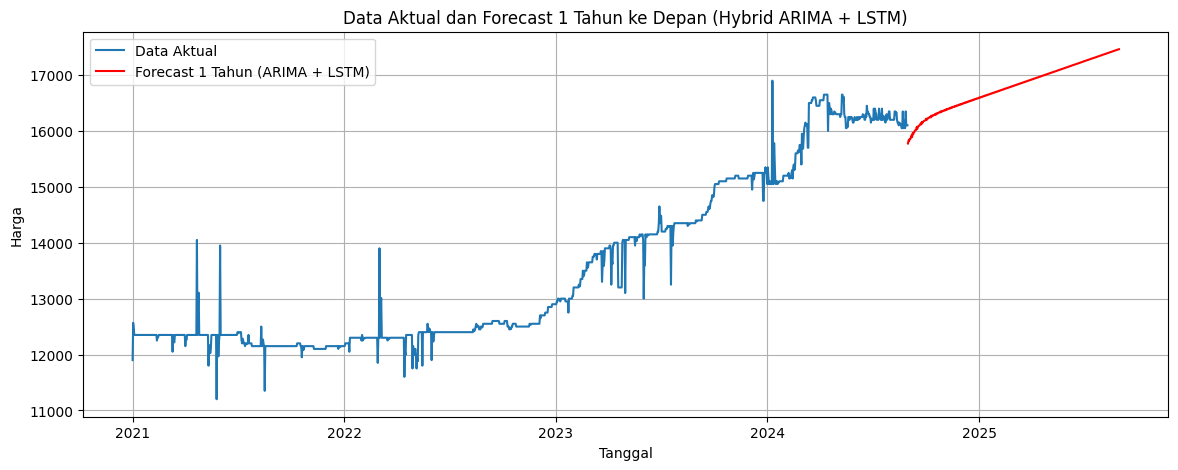

In [ ]:
# 1. Plot data aktual
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Harga (Rp)'], label='Data Aktual')  # Plot data aktual dari awal

# 7. Plot prediksi ARIMA + LSTM untuk 1 tahun ke depan
plt.plot(forecast_dates, final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)', color='red')

# 8. Menambahkan judul, legend, dan menampilkan plot
plt.title('Data Aktual dan Forecast 1 Tahun ke Depan (Hybrid ARIMA + LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create a DataFrame for the extended forecast data

# Simpan hanya hasil forecast ke dalam file CSV
final_forecast.to_csv('hybrid70.csv', header=True)

# LSTM RESIDUAL 60-40


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Modelling

In [ ]:
arraydata = df['Harga (Rp)'].values

In [ ]:
train_size = int(len(arraydata) * 0.8)
train_data, test_data = arraydata[:train_size], arraydata[train_size:]

In [ ]:
arima_order = (10, 2, 1)  # Tentukan parameter ARIMA yang optimal (p, d, q)
arima_model = ARIMA(train_data, order=arima_order)
arima_model_fit = arima_model.fit()

In [ ]:
arima_pred = arima_model_fit.forecast(steps=len(test_data))
arima_train_pred = arima_model_fit.fittedvalues

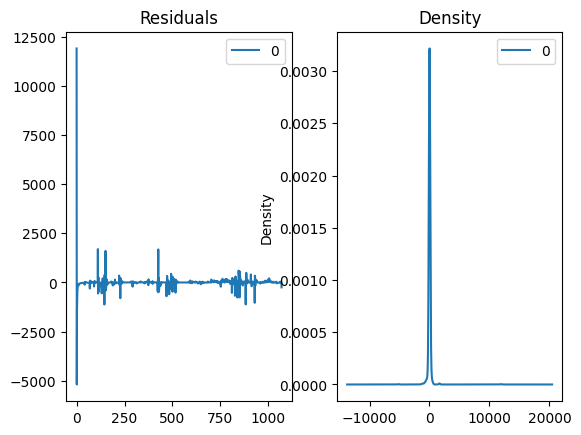

In [ ]:
import matplotlib.pyplot as plt
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

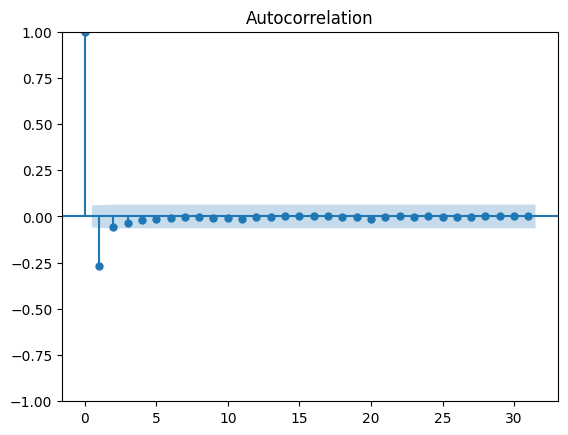

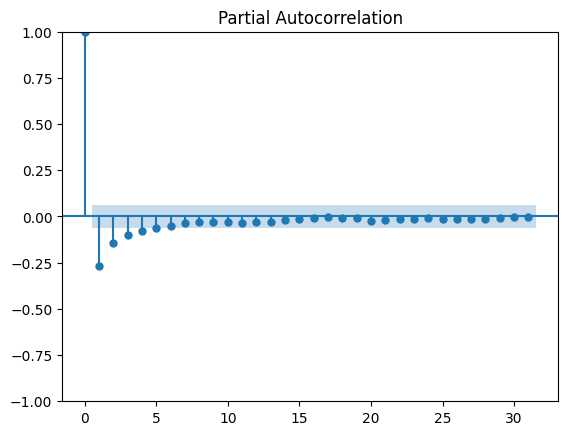

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_residuals = plot_acf(residuals)
pacf_residuals = plot_pacf(residuals)

In [ ]:
# 6. Hitung residual dari ARIMA (pola non-linear yang tertinggal)
train_residual = train_data - arima_train_pred
test_residual = test_data - arima_pred

train_residual
test_residual

array([  77.48097293,  133.4423808 ,   16.19534737,   53.73480696,
         95.20811217,   65.02779177,   79.60445381,   80.2607128 ,
         78.07684694,   86.46514595,   94.70223619,   88.85158823,
         85.1604059 ,   80.85294804,   75.40968386,   69.10099494,
         63.63779236,   61.73145027, -440.63051405, -442.60909829,
         56.20959662,   54.69830199,  152.34291694,   82.51882084,
         90.5087175 , -156.7037535 ,  139.96074518,  -13.17454338,
       -166.00071541, -168.7155671 , -121.31764759, -156.83900897,
       -176.38434822, -179.02142899, 1668.25369491,  165.47486877,
       -187.34720047,  542.81370789,  167.99702676, -145.78329029,
       -198.53449704, -151.26240718, -153.97631174, -206.69022918,
       -176.41511754, -184.15358445, -164.90342398, -167.66182104,
       -170.42384689, -173.1840318 , -175.93942818, -178.68960943,
       -181.43535671,  -84.17828875,  -86.92058586,  -89.66407526,
        -92.4095836 ,  -95.15714438,  -97.90632784, -100.65634

In [ ]:
# 7. Scale data residual untuk LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.reshape(-1, 1))

In [ ]:
# 8. Create dataset for LSTM (gunakan residual untuk training)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_residual_scaled, look_back)
X_test, y_test = create_dataset(test_residual_scaled, look_back)# 8. Create dataset for LSTM (gunakan residual untuk training)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train_residual_scaled, look_back)
X_test, y_test = create_dataset(test_residual_scaled, look_back)

In [ ]:
# Reshape input to [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# 9. Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

In [ ]:
# 10. Compile and train LSTM
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0154
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.0228e-04
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.1187e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.6971e-05
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.5025e-05
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.9217e-05
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.0060e-04
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8.9537e-05
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 7.3423e-05
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 7.7475e-05
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 9.3217e-05
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.0453e-04
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.2020e-04
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.6500e-05
Epoch 15/20
16/16

In [ ]:
# 11. Prediksi residual menggunakan LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


In [ ]:
# 12. Gabungkan hasil prediksi ARIMA dan LSTM (prediksi residual)
final_pred = arima_pred[-len(lstm_pred_rescaled):] + lstm_pred_rescaled.flatten()


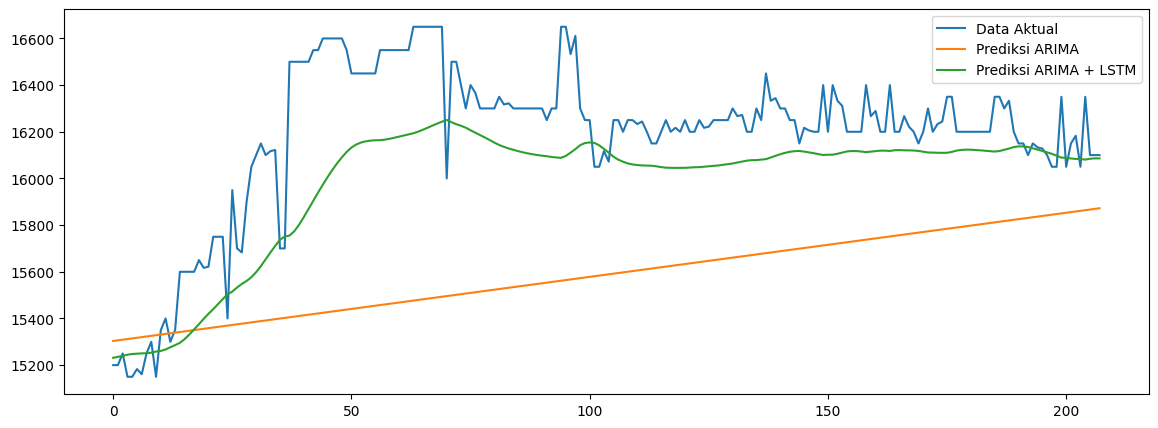

In [ ]:
# 13. Plot hasil akhir
plt.figure(figsize=(14, 5))
plt.plot(test_data[look_back:], label='Data Aktual')
plt.plot(arima_pred[-len(final_pred):], label='Prediksi ARIMA')
plt.plot(final_pred, label='Prediksi ARIMA + LSTM')
plt.legend()
plt.show()


## Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test_data[look_back:], final_pred)
mae = mean_absolute_error(test_data[look_back:], final_pred)
mape = np.mean(np.abs((test_data[look_back:] - final_pred) / test_data[look_back:])) * 100
r2 = r2_score(test_data[look_back:], final_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')

MSE: 71216.66576369457
MAE: 212.30283186425063
MAPE: 1.3022647481486076
R²: 0.3838345106651686


## Implementation

In [ ]:
lstm_input = test_residual_scaled[-look_back:]
lstm_input = lstm_input.reshape((1, look_back, 1))

In [ ]:
lstm_forecast_residuals = []
for _ in range(forecast_steps):
    lstm_pred_residual = lstm_model.predict(lstm_input)
    lstm_forecast_residuals.append(lstm_pred_residual[0, 0])

    lstm_input = np.append(lstm_input[0, 1:], lstm_pred_residual)
    lstm_input = lstm_input.reshape((1, look_back, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [ ]:
lstm_forecast_residuals_rescaled = scaler.inverse_transform(np.array(lstm_forecast_residuals).reshape(-1, 1))

In [ ]:
final_forecast = extended_forecast + lstm_forecast_residuals_rescaled.flatten()

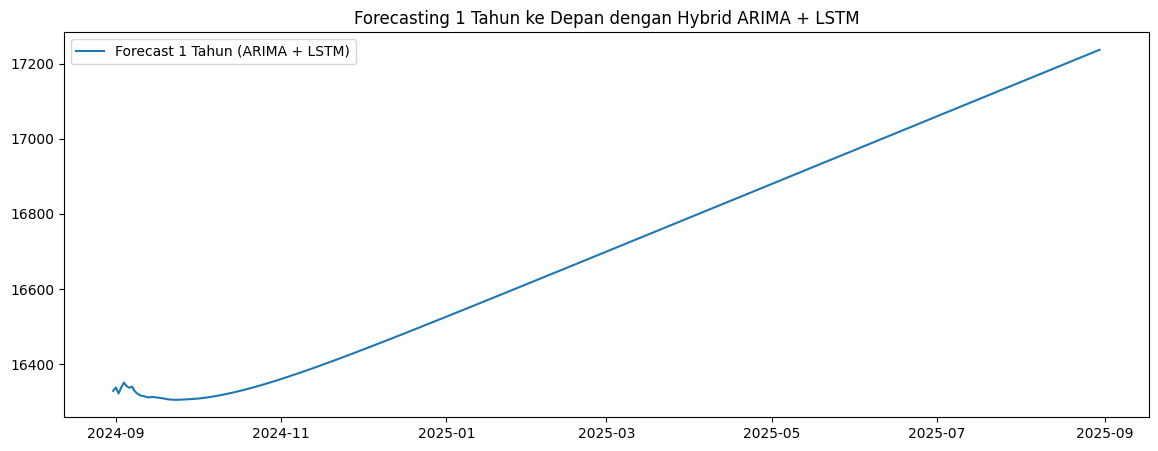

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)')
plt.title('Forecasting 1 Tahun ke Depan dengan Hybrid ARIMA + LSTM')
plt.legend()
plt.show()

In [ ]:
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, inclusive='right')
forecast_df = pd.DataFrame(final_forecast, index=forecast_dates, columns=['Forecast'])

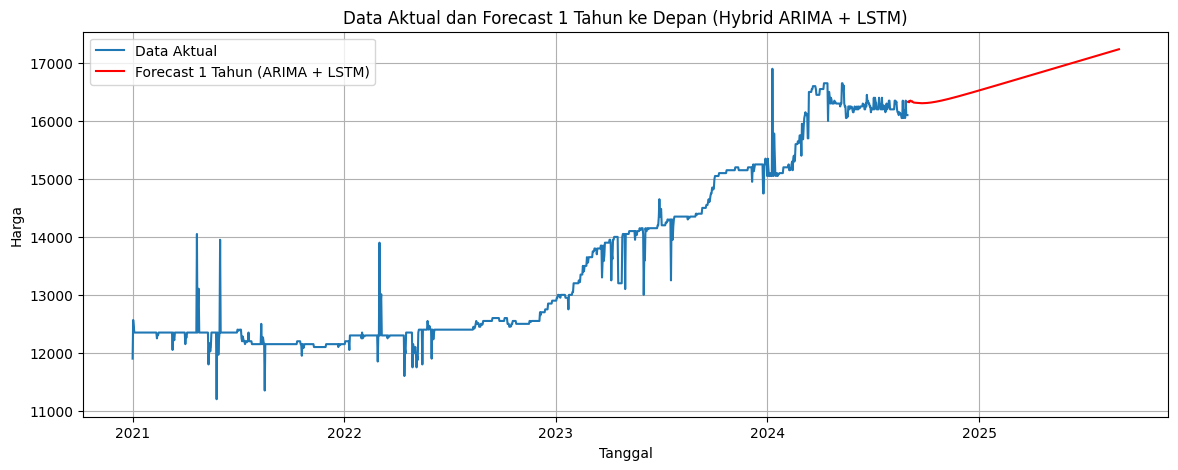

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Harga (Rp)'], label='Data Aktual')

plt.plot(forecast_dates, final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)', color='red')

plt.title('Data Aktual dan Forecast 1 Tahun ke Depan (Hybrid ARIMA + LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
final_forecast.to_csv('hybrid60.csv', header=True)

# Grafik Gabungan

## 80%

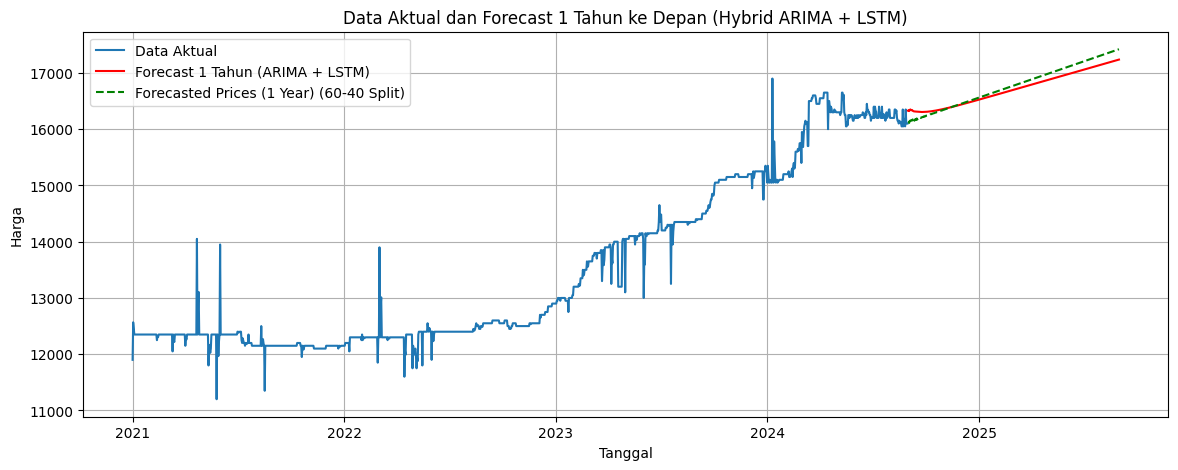

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Harga (Rp)'], label='Data Aktual')

plt.plot(forecast_dates, final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)', color='red')

plt.plot(future_dates, extended_forecast_80, label="Forecasted Prices (1 Year) (60-40 Split)", color="green", linestyle="--")

plt.title('Data Aktual dan Forecast 1 Tahun ke Depan (Hybrid ARIMA + LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

## 70%

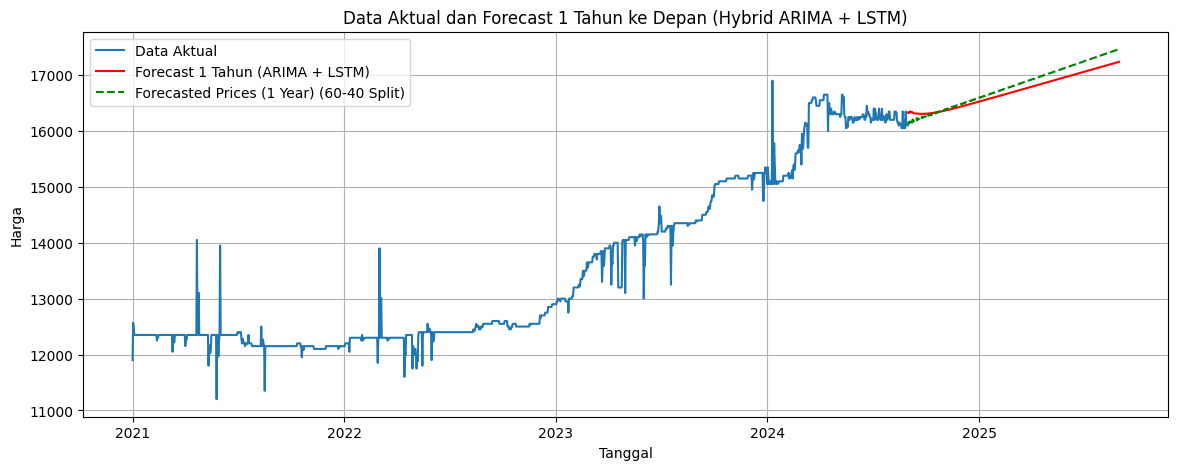

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Harga (Rp)'], label='Data Aktual')

plt.plot(forecast_dates, final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)', color='red')

plt.plot(future_dates, extended_forecast_70, label="Forecasted Prices (1 Year) (60-40 Split)", color="green", linestyle="--")

plt.title('Data Aktual dan Forecast 1 Tahun ke Depan (Hybrid ARIMA + LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

## 60%

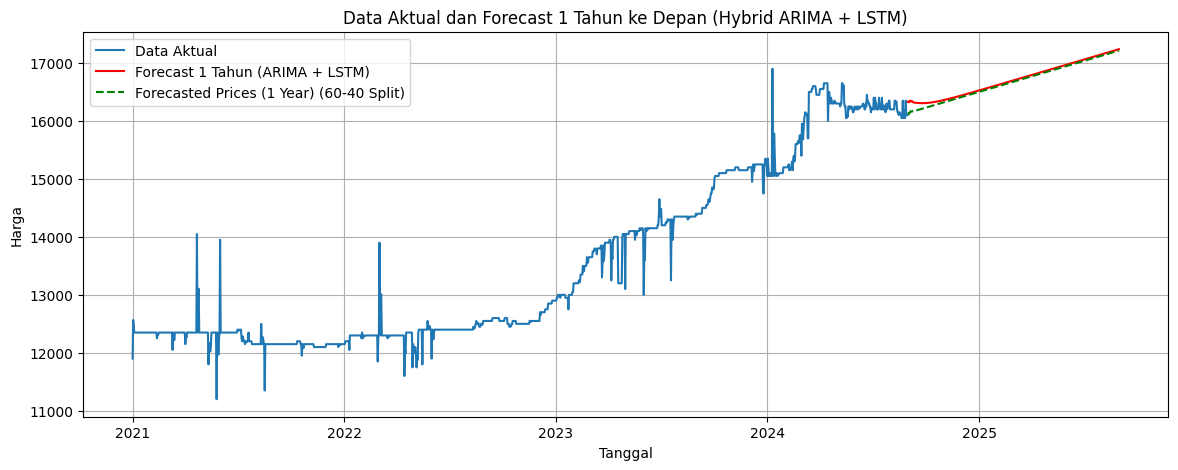

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Harga (Rp)'], label='Data Aktual')

plt.plot(forecast_dates, final_forecast, label='Forecast 1 Tahun (ARIMA + LSTM)', color='red')

plt.plot(future_dates, extended_forecast, label="Forecasted Prices (1 Year) (60-40 Split)", color="green", linestyle="--")

plt.title('Data Aktual dan Forecast 1 Tahun ke Depan (Hybrid ARIMA + LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()